In [2]:
import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
# !pip install lightgbm
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import learning_curve
# from yellowbrick.model_selection import learning_curve


# SMOTE and Near Miss
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler

# !pip install 'aif360[AdversarialDebiasing]'
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer
# from aif360.algorithms.preprocessing import Reweighing

plt.style.use("fivethirtyeight")

from IPython.display import display, HTML

import warnings
print('Ok')

Ok


In [4]:
def logTime(msg):
    print('{} \t{}'.format(msg, datetime.datetime.now()))
logTime('Process start')

Process start 	2022-03-14 17:32:50.461786


In [5]:
%%time
data = pd.read_csv("""..\data\interim\data_100000-30percent.csv""")
data2 = data.drop(['customer'], axis=1)
# data2 = data2.drop(['tenure'], axis=1)
# data2 = data2.drop(['comeback_product'], axis=1)

data2['gender'] = data2['gender'].astype(int)
# data2['churn'] = data2['churn'].astype(object)
data2['is_senior'] = data2['is_senior'].astype(int)
data2['contract_period'] = data2['contract_period'].astype(object)

numerical = data2.select_dtypes(['number']).columns
print(f'Numerical: {numerical}\n')

categorical = data2.columns.difference(numerical)

data2[categorical] = data2[categorical].astype('object')
print(f'Categorical: {categorical}')

data2 = pd.get_dummies(data2)

X_original = data2.drop('churn', axis=1)
y_original = data2['churn']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 42)
print(len(data2.keys()))
data2.keys()

Numerical: Index(['age', 'gender', 'hsbb_area', 'speed', 'price_start', 'complain_count',
       'churn', 'median_outstanding', 'technical_problem_count', 'is_senior',
       'avg_download', 'avg_upload', 'avg_voice_usage'],
      dtype='object')

Categorical: Index(['contract_period', 'race', 't_location'], dtype='object')
46
Wall time: 174 ms


Index(['age', 'gender', 'hsbb_area', 'speed', 'price_start', 'complain_count',
       'churn', 'median_outstanding', 'technical_problem_count', 'is_senior',
       'avg_download', 'avg_upload', 'avg_voice_usage', 'race_B', 'race_C',
       'race_I', 'race_M', 'race_O', 't_location_Zone-AJP',
       't_location_Zone-AKM', 't_location_Zone-BAL', 't_location_Zone-BKK',
       't_location_Zone-BLS', 't_location_Zone-CSM', 't_location_Zone-GCK',
       't_location_Zone-GHP', 't_location_Zone-GPP', 't_location_Zone-GRT',
       't_location_Zone-IRM', 't_location_Zone-KDS', 't_location_Zone-KRP',
       't_location_Zone-NSN', 't_location_Zone-PBP', 't_location_Zone-PDK',
       't_location_Zone-RLK', 't_location_Zone-SRJ', 't_location_Zone-TLK',
       't_location_Zone-TLS', 't_location_Zone-UBS', 't_location_Zone-URJ',
       't_location_Zone-UWT', 'contract_period_1', 'contract_period_12',
       'contract_period_18', 'contract_period_24', 'contract_period_36'],
      dtype='object')

In [6]:
models = []
models.append(('Random Forest', RandomForestClassifier()))
models.append(("LightGBM", LGBMClassifier()))
models.append(('Gradient Boosting', GradientBoostingClassifier()))
models.append(('Logistic Reg.', LogisticRegression(max_iter=1000)))

models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))

methods = ['original', 'adasyn', 'smote', 'rus', 'ros']

In [7]:
# AIF360 Dataset Preparation

all_labels = ['age', 'gender', 'hsbb_area', 'speed', 'price_start', 'complain_count',
       'churn', 'median_outstanding', 'technical_problem_count', 'is_senior',
       'avg_download', 'avg_upload', 'avg_voice_usage', 'race_B', 'race_C',
       'race_I', 'race_M', 'race_O', 't_location_Zone-AJP',
       't_location_Zone-AKM', 't_location_Zone-BAL', 't_location_Zone-BKK',
       't_location_Zone-BLS', 't_location_Zone-CSM', 't_location_Zone-GCK',
       't_location_Zone-GHP', 't_location_Zone-GPP', 't_location_Zone-GRT',
       't_location_Zone-IRM', 't_location_Zone-KDS', 't_location_Zone-KRP',
       't_location_Zone-NSN', 't_location_Zone-PBP', 't_location_Zone-PDK',
       't_location_Zone-RLK', 't_location_Zone-SRJ', 't_location_Zone-TLK',
       't_location_Zone-TLS', 't_location_Zone-UBS', 't_location_Zone-URJ',
       't_location_Zone-UWT', 
        # 'contract_period_1', 
        'contract_period_12',
       'contract_period_18', 'contract_period_24', 'contract_period_36']

features = ['age', 'gender', 'hsbb_area', 'speed', 'price_start', 'complain_count',
       'churn', 'median_outstanding', 'technical_problem_count', 'is_senior',
       'avg_download', 'avg_upload', 'avg_voice_usage', 'race_B', 'race_C',
       'race_I', 'race_M', 'race_O', 't_location_Zone-AJP',
       't_location_Zone-AKM', 't_location_Zone-BAL', 't_location_Zone-BKK',
       't_location_Zone-BLS', 't_location_Zone-CSM', 't_location_Zone-GCK',
       't_location_Zone-GHP', 't_location_Zone-GPP', 't_location_Zone-GRT',
       't_location_Zone-IRM', 't_location_Zone-KDS', 't_location_Zone-KRP',
       't_location_Zone-NSN', 't_location_Zone-PBP', 't_location_Zone-PDK',
       't_location_Zone-RLK', 't_location_Zone-SRJ', 't_location_Zone-TLK',
       't_location_Zone-TLS', 't_location_Zone-UBS', 't_location_Zone-URJ',
       't_location_Zone-UWT', 
        # 'contract_period_1', 
        'contract_period_12',
       'contract_period_18', 'contract_period_24', 'contract_period_36']


class TMDataset(StandardDataset):
    def __init__(self, 
             label_name='churn',
             favorable_classes=[1.0],
                 
             protected_attribute_names=[
                'gender', 
#                 'is_senior',
#                 'race_O',
             ],
    
             privileged_classes=[
                [1.0,], 
#                 [0.0,],
#                 [0.0,],
             ],
                 
             instance_weights_name=None,
             categorical_features=[],
             features_to_keep=features, 
             features_to_drop=[],
             custom_preprocessing=None,
             metadata=None,
             csv_file_name='',
             data_frame=None,
    ):
        
        if data_frame is not None:
            aif_df = data_frame
        else:
            aif_df = pd.read_csv(csv_file_name)
        
        #df.reset_index(drop=True, inplace=True)
        # Preprocessing
        
        super().__init__(
            df=aif_df, label_name=label_name,
            favorable_classes=favorable_classes,
            protected_attribute_names=protected_attribute_names,
            privileged_classes=privileged_classes,
            instance_weights_name=instance_weights_name,
            categorical_features=categorical_features,
            features_to_keep=features_to_keep,
            features_to_drop=features_to_drop,
            custom_preprocessing=custom_preprocessing, 
            metadata=metadata,
     
        )

In [8]:
def make_sampling(method_name, X, y):
    if method_name == 'original':
        return (X, y)
    elif method_name == 'adasyn':
        adasyn = ADASYN(sampling_strategy='minority', random_state=420, n_neighbors=5)
        return adasyn.fit_resample(X, y)
    elif method_name == 'smote':
        os = SMOTE(random_state=41)
        return os.fit_resample(X, y)
    elif method_name == 'ros':
        random_over_sampler = RandomOverSampler(random_state=42)
        return random_over_sampler.fit_resample(X, y)
    elif method_name == 'rus':
        random_under_sampler = RandomUnderSampler(random_state=42)
        return random_under_sampler.fit_resample(X, y)
    else:
        print('UNKNOWN METHOD !!') 


In [9]:
def create_learningcurve(classfier, X, y):
    # classfier = model
    # print('Process started at {}'.format(datetime.datetime.now())) 
    train_sizes_initial = np.linspace(0.01, 1.0, 50)
    train_sizes, train_scores, test_scores = learning_curve(
        classfier, X, y, cv=10, scoring='accuracy', 
        n_jobs=-1, train_sizes=train_sizes_initial)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.subplots(1, figsize=(10,10))
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()

    plt.pause(0.05)
    # print('Process end at {}'.format(datetime.datetime.now())) 
    # print(learning_curve(model, X, y, cv=30, scoring='accuracy'))

    # end plot

In [10]:
def runModels(model_index, method_index):
    name, model = models[model_index - 1]
    method = methods[method_index - 1]
    display(HTML(f'<h2>{model_index}.{method_index} {name} - {method} </h2>'))
    time.sleep(1)
    
    time.sleep(1)
    method_index += 1
    # display(HTML(f'<h3> {model_index}.{method_index} {method} </h3>'))
    X, y = make_sampling(method, X_original, y_original)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 42)
    score = cross_val_score(model, X, y, cv = 10, scoring='accuracy')

    print('Charn values Original')
    print(y.value_counts())
    print('Total data: {}'.format(y.count()))

    print('\nCharn values Train')
    print(y_train.value_counts())
    print('Total data: {}'.format(y_train.count()))

    print('\nCharn values Test')
    print(y_test.value_counts())
    print('Total data: {}'.format(y_test.count()))

    print("\n")
    print("*_" * 20)
    print(f"Mean scores : {score.mean()}")

    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print(metrics.classification_report(y_pred_test, y_test))

    # Learning curve start
    print('Creating Learning curve for {} - {}'.format(name, method))
    %time create_learningcurve(model, X, y)

    pred_df = X_test.copy()
    pred_df['churn'] = y_pred_test

    print('\n Gender Count in predited value with X_test set')
    print('# ' * 10)
    print(pred_df.gender.value_counts())
    p_df = pred_df[['churn', 'gender']]
    print('\n')
    p_df.insert(2, 'counter', 1)
    print(p_df.groupby(['churn','gender',]).sum())
    print('# ' * 10)

    print(metrics.confusion_matrix(y_test, y_pred_test))
    metrics.plot_confusion_matrix(model, X_test, y_test)
    plt.show()

    y_proba = model.predict_proba(X_test)[:, 1]
    roc_auc_score = metrics.roc_auc_score(y_test, y_proba)
    print('\n\n')
    print(f'ROC AUC Score {roc_auc_score}')


    # Additional matrix
    df_pred = X_test
    df_pred.reset_index(drop=True, inplace=True)

    pred = pd.Series(y_pred_test)
    df_pred = df_pred.assign(churn=pred)

    # df_pred = df_pred.assign(churn=y_test)

    aif_df = TMDataset(data_frame=df_pred)
    aif_df_labeled = aif_df.copy()
    aif_df_labeled.labels = y_pred_test

    result_tbl_cols = [
        'Attribute',
        'Mean difference', 
        'Positive Outcome',
        'Negative', 
        'Differences', 
        'Disparate impact', 
        'Consistency',
        'Statistical parity dif',
    ]

    result_rows = []
    for p_attribute in aif_df.protected_attribute_names:
        result_row = []
        privileged_groups = [{p_attribute: 1}]
        print(' * ' * 10)
        print(privileged_groups)
        unprivileged_groups = [{p_attribute: 0}]

        metric_orig_train = BinaryLabelDatasetMetric(
            aif_df,  unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

        clsf_metric = ClassificationMetric(
            aif_df, aif_df_labeled, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

        print('\n AIF 360 ')
        print('\n Statistical parity difference', clsf_metric.statistical_parity_difference())

        print('\n True possitve rate {} \t True negative rate {} '.format(
            clsf_metric.true_positive_rate(), clsf_metric.true_negative_rate()))

        print('\n Desparate impact ', clsf_metric.disparate_impact())
        print('\n Equal opportunity difference ', clsf_metric.equal_opportunity_difference())
        print('\n Average odds difference ', clsf_metric.average_odds_difference())
        print('\n Theil Index ', clsf_metric.theil_index())
        print('\n Binary Confusion Matric ')
        print(clsf_metric.binary_confusion_matrix())
        print('\n ..........................')

        text_expl = MetricTextExplainer(metric_orig_train)

        result_row.append(p_attribute)
        result_row.append(metric_orig_train.mean_difference())
        result_row.append(metric_orig_train.num_positives())
        result_row.append(metric_orig_train.num_negatives())

        # this is to shutup the warning msg from sklearn
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', FutureWarning)
            result_row.append(metric_orig_train.consistency())

        result_row.append(metric_orig_train.disparate_impact())
        result_row.append(metric_orig_train.consistency())
        result_row.append(metric_orig_train.statistical_parity_difference())

        result_rows.append(result_row)

    result_df = pd.DataFrame(result_rows, columns=result_tbl_cols)
    display(result_df)
    # End Aif matrix

Charn values Original
0    70000
1    30000
Name: churn, dtype: int64
Total data: 100000

Charn values Train
0    46896
1    20104
Name: churn, dtype: int64
Total data: 67000

Charn values Test
0    23104
1     9896
Name: churn, dtype: int64
Total data: 33000


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.8057399999999999
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     26768
           1       0.49      0.77      0.60      6232

    accuracy                           0.80     33000
   macro avg       0.71      0.79      0.73     33000
weighted avg       0.85      0.80      0.82     33000

Creating Learning curve for Random Forest - original


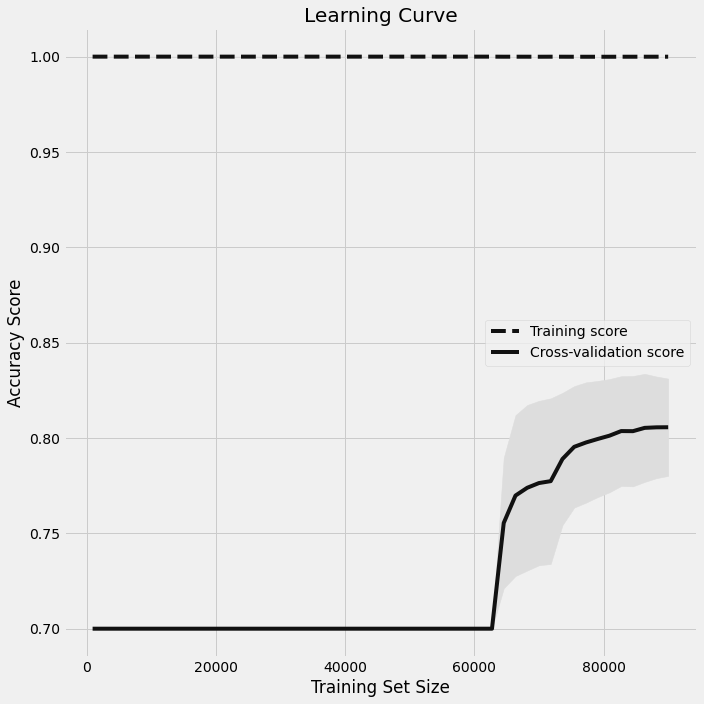

Wall time: 4min 51s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    20349
0    12651
Name: gender, dtype: int64


              counter
churn gender         
0     0         10530
      1         16238
1     0          2121
      1          4111
# # # # # # # # # # 
[[21696  1408]
 [ 5072  4824]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


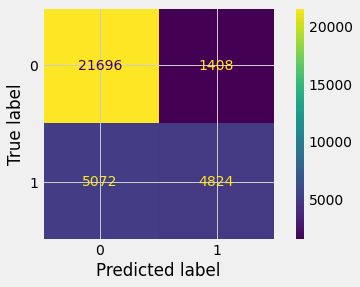




ROC AUC Score 0.8162873520170717
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.03436993866561347

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.8298725658218028

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 6232.0, 'FP': 0.0, 'TN': 26768.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.03437,6232.0,26768.0,[0.901139393939399],0.829873,[0.901139393939399],-0.03437


Wall time: 7min 12s


In [10]:
%%time
# Random Forest Original
runModels(1, 1)

Charn values Original
1    75259
0    70000
Name: churn, dtype: int64
Total data: 145259

Charn values Train
1    50355
0    46968
Name: churn, dtype: int64
Total data: 97323

Charn values Test
1    24904
0    23032
Name: churn, dtype: int64
Total data: 47936


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.8507086828460949
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     25647
           1       0.81      0.90      0.85     22289

    accuracy                           0.86     47936
   macro avg       0.86      0.86      0.86     47936
weighted avg       0.86      0.86      0.86     47936

Creating Learning curve for Random Forest - adasyn


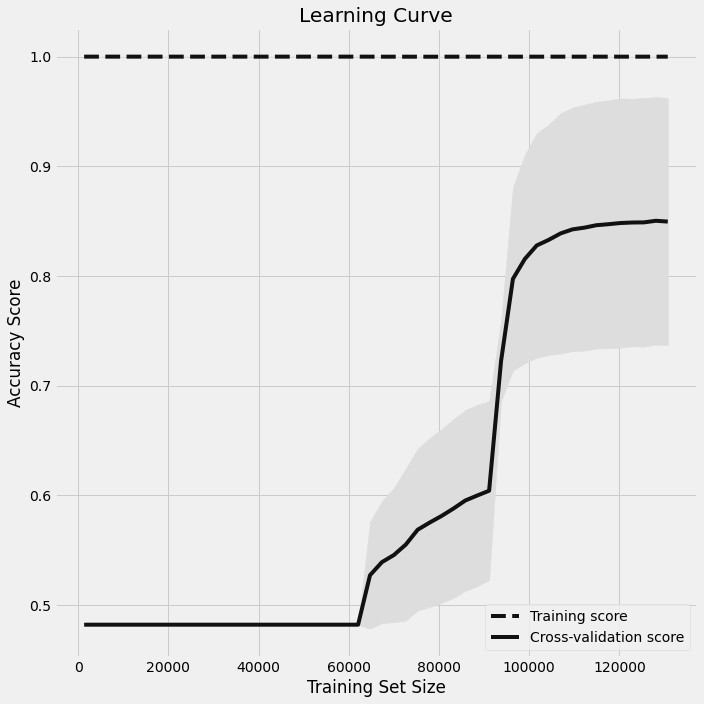

Wall time: 11min 6s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    26520
0    21416
Name: gender, dtype: int64


              counter
churn gender         
0     0         10111
      1         15536
1     0         11305
      1         10984
# # # # # # # # # # 
[[20912  2120]
 [ 4735 20169]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


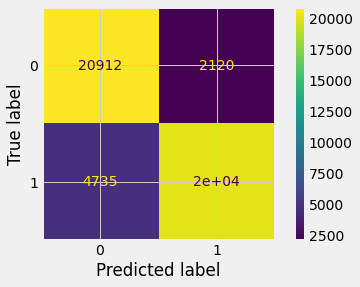




ROC AUC Score 0.9233223605738778
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.11369837524389365

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.274515742122001

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 22289.0, 'FP': 0.0, 'TN': 25647.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.113698,22289.0,25647.0,[0.690278704939893],1.274516,[0.690278704939893],0.113698


Wall time: 15min 35s


In [11]:
%%time
# Random Forest [Adasyn]
runModels(1, 2)

Charn values Original
1    70000
0    70000
Name: churn, dtype: int64
Total data: 140000

Charn values Train
1    46923
0    46877
Name: churn, dtype: int64
Total data: 93800

Charn values Test
0    23123
1    23077
Name: churn, dtype: int64
Total data: 46200


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.8488571428571428
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     25894
           1       0.79      0.90      0.84     20306

    accuracy                           0.85     46200
   macro avg       0.85      0.86      0.85     46200
weighted avg       0.86      0.85      0.85     46200

Creating Learning curve for Random Forest - smote


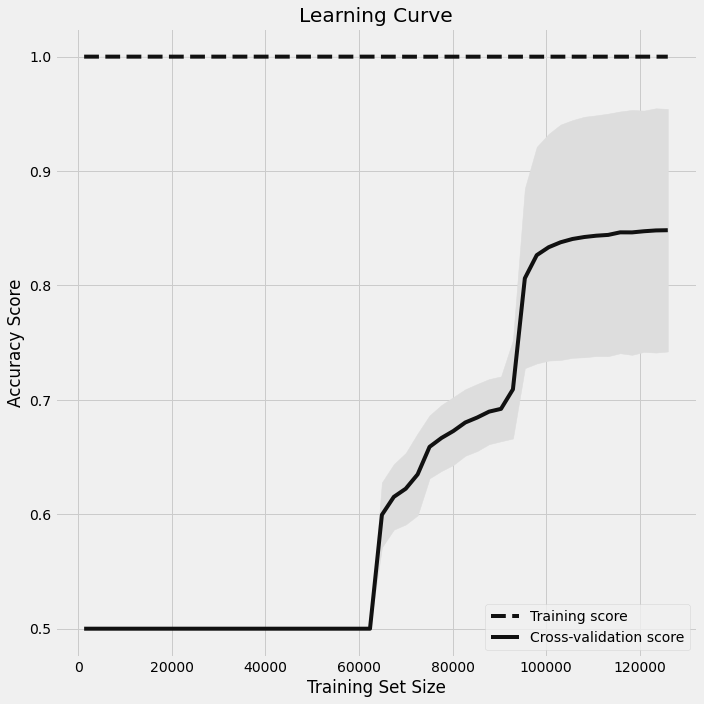

Wall time: 10min 30s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    25910
0    20290
Name: gender, dtype: int64


              counter
churn gender         
0     0         10176
      1         15718
1     0         10114
      1         10192
# # # # # # # # # # 
[[21124  1999]
 [ 4770 18307]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


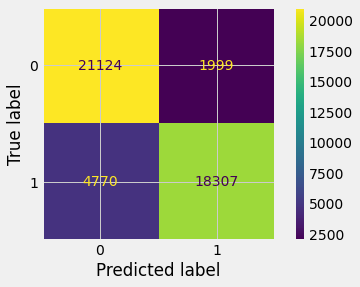




ROC AUC Score 0.9182341846027692
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.10511051733652088

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.2672109011174701

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 20306.0, 'FP': 0.0, 'TN': 25894.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.105111,20306.0,25894.0,[0.7571125541125479],1.267211,[0.7571125541125479],0.105111


Wall time: 14min 2s


In [12]:
%%time
# Random Forest [Smote]
runModels(1, 3)

Charn values Original
1    30000
0    30000
Name: churn, dtype: int64
Total data: 60000

Charn values Train
0    20167
1    20033
Name: churn, dtype: int64
Total data: 40200

Charn values Test
1    9967
0    9833
Name: churn, dtype: int64
Total data: 19800


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.7395333333333334
              precision    recall  f1-score   support

           0       0.80      0.72      0.76     10951
           1       0.69      0.78      0.73      8849

    accuracy                           0.74     19800
   macro avg       0.74      0.75      0.74     19800
weighted avg       0.75      0.74      0.75     19800

Creating Learning curve for Random Forest - rus


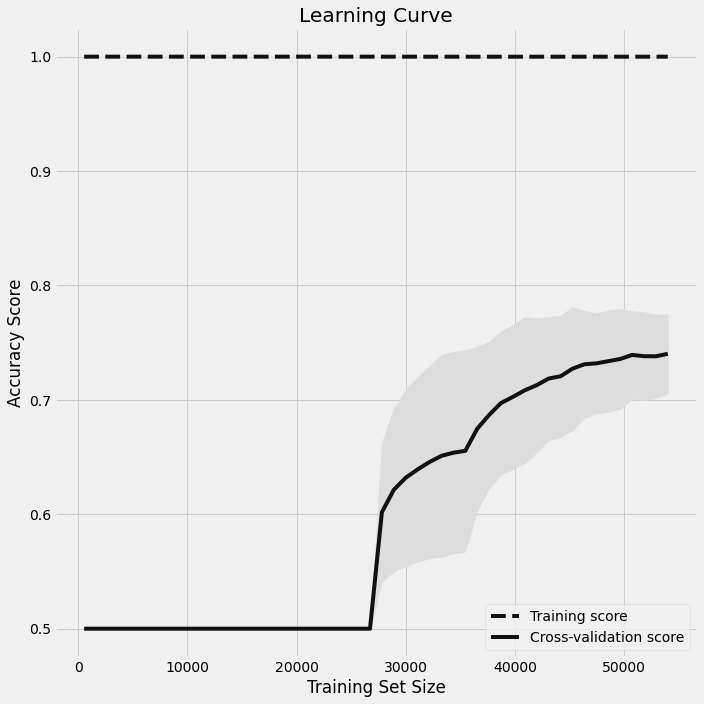

Wall time: 3min 19s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    12284
0     7516
Name: gender, dtype: int64


              counter
churn gender         
0     0          4370
      1          6581
1     0          3146
      1          5703
# # # # # # # # # # 
[[7861 1972]
 [3090 6877]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


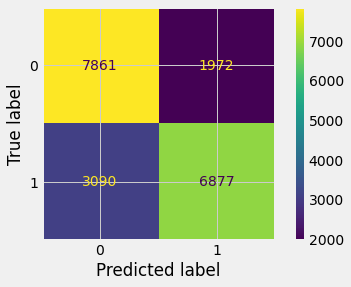




ROC AUC Score 0.8215055834972381
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.04568874580640647

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.9015885405074703

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 8849.0, 'FP': 0.0, 'TN': 10951.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.045689,8849.0,10951.0,[0.7543737373737541],0.901589,[0.7543737373737541],-0.045689


Wall time: 4min 35s


In [13]:
%%time
# Random Forest [Rus]
runModels(1, 4)

Charn values Original
1    70000
0    70000
Name: churn, dtype: int64
Total data: 140000

Charn values Train
1    46923
0    46877
Name: churn, dtype: int64
Total data: 93800

Charn values Test
0    23123
1    23077
Name: churn, dtype: int64
Total data: 46200


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.9213214285714286
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     22576
           1       0.90      0.88      0.89     23624

    accuracy                           0.89     46200
   macro avg       0.89      0.89      0.89     46200
weighted avg       0.89      0.89      0.89     46200

Creating Learning curve for Random Forest - ros


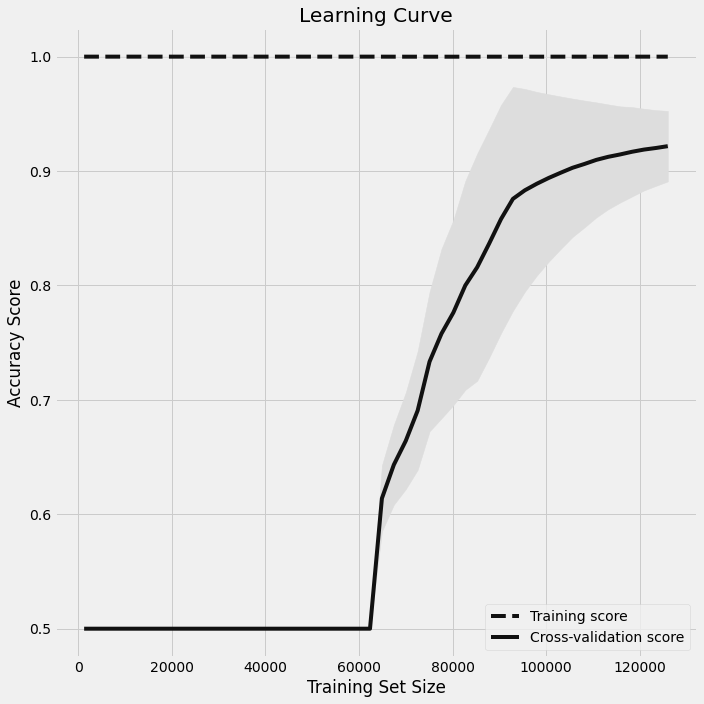

Wall time: 10min 6s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    28703
0    17497
Name: gender, dtype: int64


              counter
churn gender         
0     0          9050
      1         13526
1     0          8447
      1         15177
# # # # # # # # # # 
[[20278  2845]
 [ 2298 20779]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


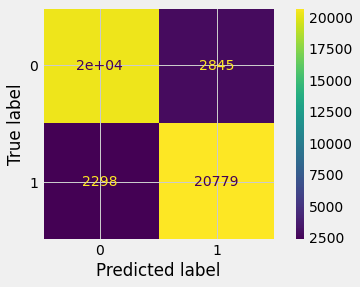




ROC AUC Score 0.9496982831850823
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.04599158532840475

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.9130199332093825

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 23624.0, 'FP': 0.0, 'TN': 22576.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.045992,23624.0,22576.0,[0.7355800865800761],0.91302,[0.7355800865800761],-0.045992


Wall time: 13min 11s


In [11]:
%%time
# Random Forest [Ros]
runModels(1, 5)

Charn values Original
0    70000
1    30000
Name: churn, dtype: int64
Total data: 100000

Charn values Train
0    46896
1    20104
Name: churn, dtype: int64
Total data: 67000

Charn values Test
0    23104
1     9896
Name: churn, dtype: int64
Total data: 33000


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.80791
              precision    recall  f1-score   support

           0       0.95      0.81      0.87     26995
           1       0.48      0.80      0.60      6005

    accuracy                           0.81     33000
   macro avg       0.72      0.80      0.74     33000
weighted avg       0.86      0.81      0.82     33000

Creating Learning curve for LightGBM - original


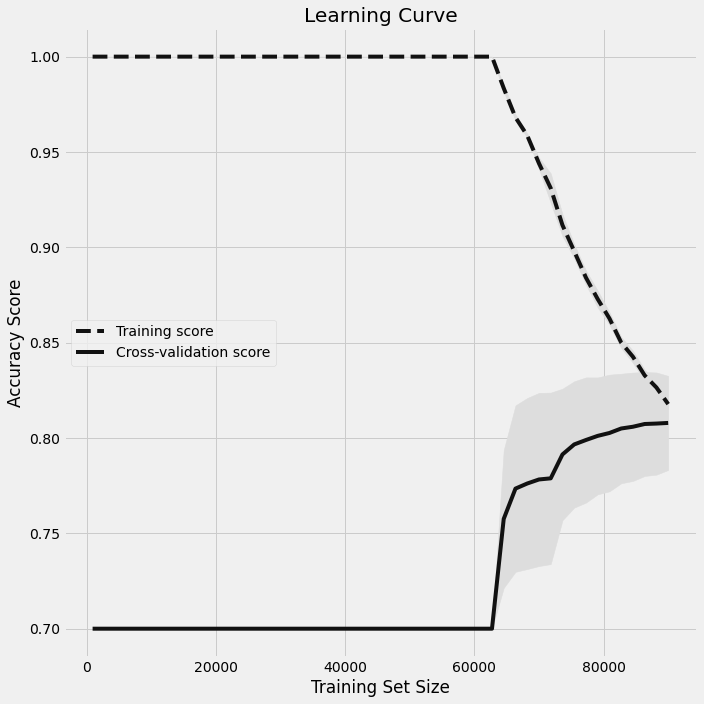

Wall time: 29.1 s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    20349
0    12651
Name: gender, dtype: int64


              counter
churn gender         
0     0         10637
      1         16358
1     0          2014
      1          3991
# # # # # # # # # # 
[[21884  1220]
 [ 5111  4785]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


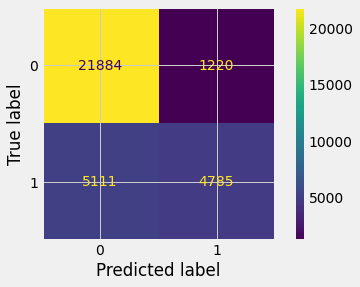




ROC AUC Score 0.8261998888159854
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.036930672405835224

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.8117007635213378

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 6005.0, 'FP': 0.0, 'TN': 26995.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.036931,6005.0,26995.0,[0.9145515151515174],0.811701,[0.9145515151515174],-0.036931


Wall time: 37.1 s


In [12]:
%%time
runModels(2, 1)

Charn values Original
1    75259
0    70000
Name: churn, dtype: int64
Total data: 145259

Charn values Train
1    50355
0    46968
Name: churn, dtype: int64
Total data: 97323

Charn values Test
1    24904
0    23032
Name: churn, dtype: int64
Total data: 47936


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.8524229524458843
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     26600
           1       0.80      0.93      0.86     21336

    accuracy                           0.86     47936
   macro avg       0.87      0.87      0.86     47936
weighted avg       0.87      0.86      0.86     47936

Creating Learning curve for LightGBM - adasyn


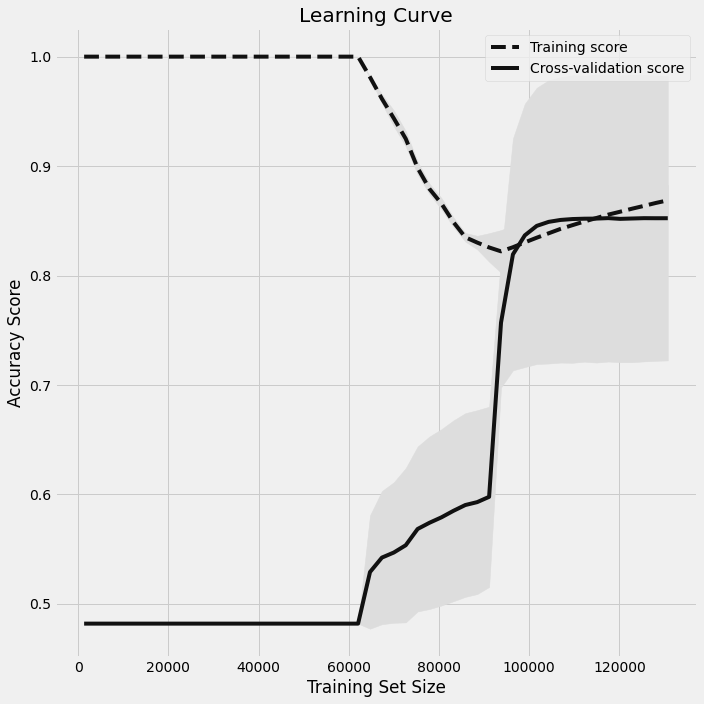

Wall time: 56.4 s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    26520
0    21416
Name: gender, dtype: int64


              counter
churn gender         
0     0         10602
      1         15998
1     0         10814
      1         10522
# # # # # # # # # # 
[[21549  1483]
 [ 5051 19853]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


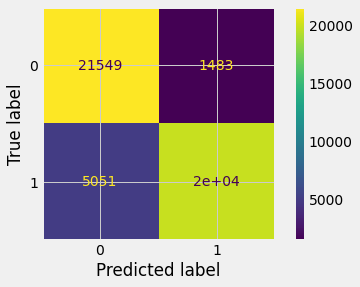




ROC AUC Score 0.9284950092342089
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.10819240601042007

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.272691751320694

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 21336.0, 'FP': 0.0, 'TN': 26600.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.108192,21336.0,26600.0,[0.6929781375166638],1.272692,[0.6929781375166638],0.108192


Wall time: 2min 12s


In [13]:
%%time
runModels(2, 2)

Charn values Original
1    70000
0    70000
Name: churn, dtype: int64
Total data: 140000

Charn values Train
1    46923
0    46877
Name: churn, dtype: int64
Total data: 93800

Charn values Test
0    23123
1    23077
Name: churn, dtype: int64
Total data: 46200


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.850757142857143
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     26690
           1       0.78      0.93      0.85     19510

    accuracy                           0.86     46200
   macro avg       0.86      0.87      0.86     46200
weighted avg       0.87      0.86      0.86     46200

Creating Learning curve for LightGBM - smote


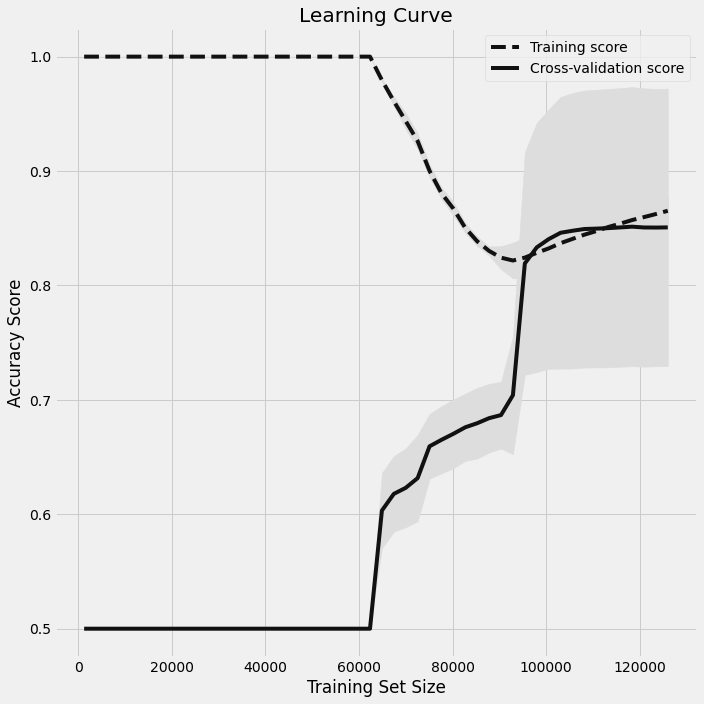

Wall time: 52.3 s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    25910
0    20290
Name: gender, dtype: int64


              counter
churn gender         
0     0         10537
      1         16153
1     0          9753
      1          9757
# # # # # # # # # # 
[[21680  1443]
 [ 5010 18067]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


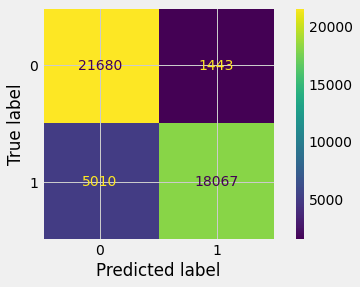




ROC AUC Score 0.9233371543737086
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.10410738616574527

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.2764602209238967

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 19510.0, 'FP': 0.0, 'TN': 26690.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.104107,19510.0,26690.0,[0.7634502164502166],1.27646,[0.7634502164502166],0.104107


Wall time: 1min 19s


In [14]:
%%time
runModels(2, 3)

Charn values Original
1    30000
0    30000
Name: churn, dtype: int64
Total data: 60000

Charn values Train
0    20167
1    20033
Name: churn, dtype: int64
Total data: 40200

Charn values Test
1    9967
0    9833
Name: churn, dtype: int64
Total data: 19800


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.74455
              precision    recall  f1-score   support

           0       0.81      0.73      0.77     10959
           1       0.70      0.79      0.74      8841

    accuracy                           0.75     19800
   macro avg       0.75      0.76      0.75     19800
weighted avg       0.76      0.75      0.75     19800

Creating Learning curve for LightGBM - rus


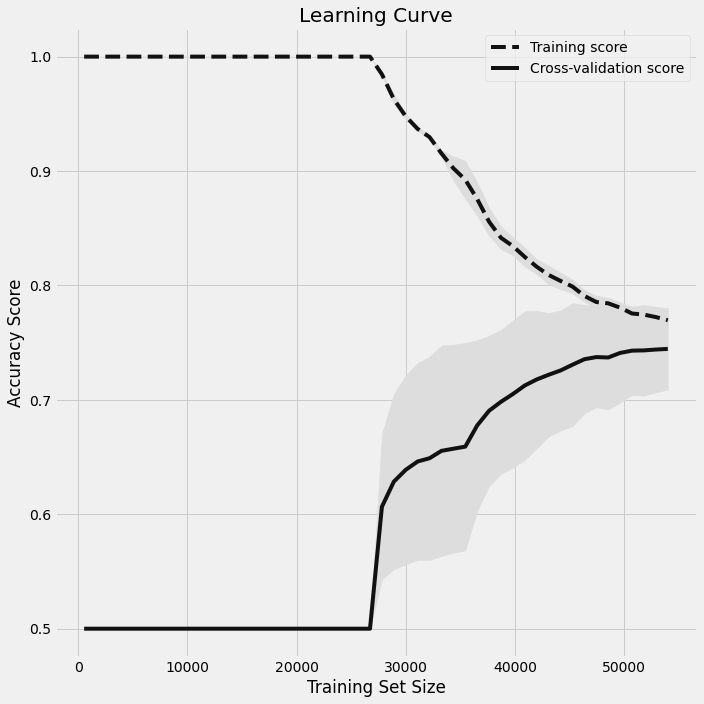

Wall time: 20.4 s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    12284
0     7516
Name: gender, dtype: int64


              counter
churn gender         
0     0          4438
      1          6521
1     0          3078
      1          5763
# # # # # # # # # # 
[[7957 1876]
 [3002 6965]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


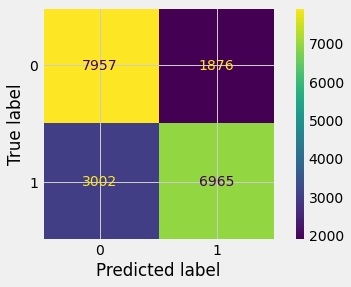




ROC AUC Score 0.8308802501932774
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.059620513901181005

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.8729171624566879

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 8841.0, 'FP': 0.0, 'TN': 10959.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.059621,8841.0,10959.0,[0.759202020202036],0.872917,[0.759202020202036],-0.059621


Wall time: 26.7 s


In [15]:
%%time
runModels(2, 4)

Charn values Original
1    70000
0    70000
Name: churn, dtype: int64
Total data: 140000

Charn values Train
1    46923
0    46877
Name: churn, dtype: int64
Total data: 93800

Charn values Test
0    23123
1    23077
Name: churn, dtype: int64
Total data: 46200


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.7532428571428571
              precision    recall  f1-score   support

           0       0.80      0.74      0.77     25268
           1       0.71      0.78      0.74     20932

    accuracy                           0.76     46200
   macro avg       0.76      0.76      0.76     46200
weighted avg       0.76      0.76      0.76     46200

Creating Learning curve for LightGBM - ros


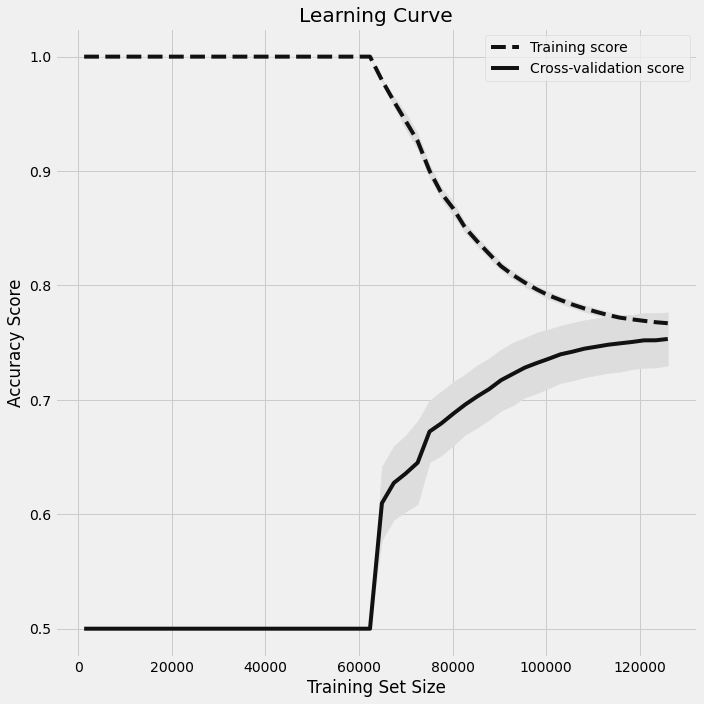

Wall time: 50.4 s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    28703
0    17497
Name: gender, dtype: int64


              counter
churn gender         
0     0         10174
      1         15094
1     0          7323
      1         13609
# # # # # # # # # # 
[[18579  4544]
 [ 6689 16388]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


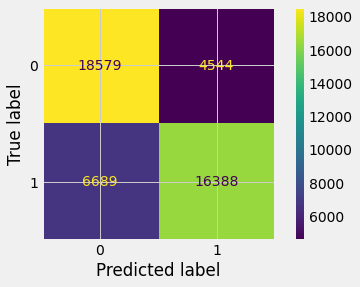




ROC AUC Score 0.8380907588875985
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.055602733205097676

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.8827272208695776

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 20932.0, 'FP': 0.0, 'TN': 25268.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.055603,20932.0,25268.0,[0.7819783549783585],0.882727,[0.7819783549783585],-0.055603


Wall time: 1min 4s


In [16]:
%%time
runModels(2, 5)

Charn values Original
0    70000
1    30000
Name: churn, dtype: int64
Total data: 100000

Charn values Train
0    46896
1    20104
Name: churn, dtype: int64
Total data: 67000

Charn values Test
0    23104
1     9896
Name: churn, dtype: int64
Total data: 33000


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.80407
              precision    recall  f1-score   support

           0       0.95      0.80      0.87     27468
           1       0.45      0.81      0.58      5532

    accuracy                           0.80     33000
   macro avg       0.70      0.81      0.73     33000
weighted avg       0.87      0.80      0.82     33000

Creating Learning curve for Gradient Boosting - original


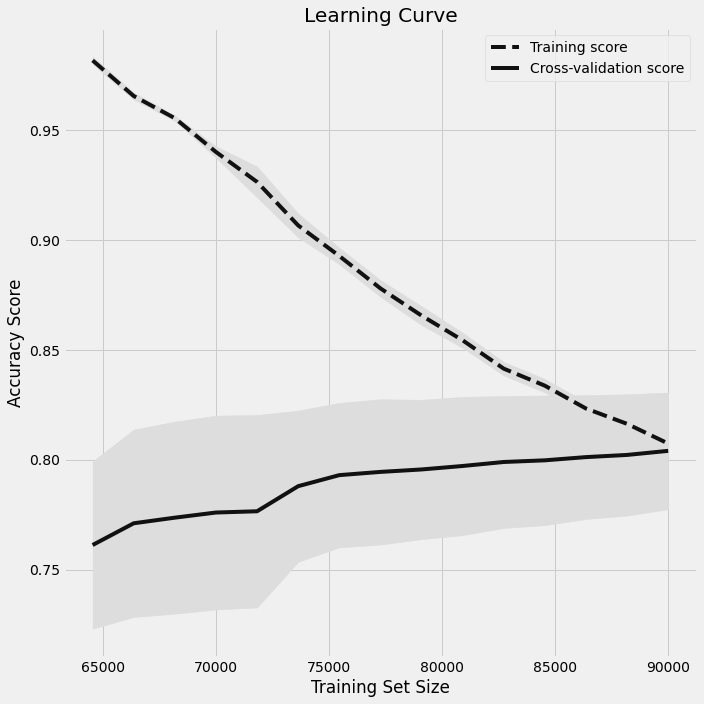

Wall time: 4min 54s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    20349
0    12651
Name: gender, dtype: int64


              counter
churn gender         
0     0         10742
      1         16726
1     0          1909
      1          3623
# # # # # # # # # # 
[[22057  1047]
 [ 5411  4485]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


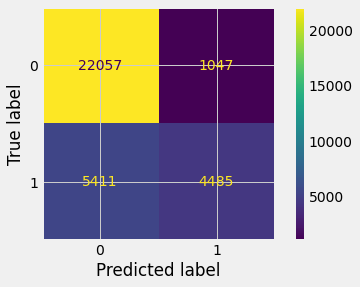




ROC AUC Score 0.817892821405638
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.027145984803733064

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.8475314256772939

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 5532.0, 'FP': 0.0, 'TN': 27468.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.027146,5532.0,27468.0,[0.9351333333333315],0.847531,[0.9351333333333315],-0.027146


Wall time: 7min 32s


In [17]:
%%time
runModels(3, 1)

Charn values Original
1    75259
0    70000
Name: churn, dtype: int64
Total data: 145259

Charn values Train
1    50355
0    46968
Name: churn, dtype: int64
Total data: 97323

Charn values Test
1    24904
0    23032
Name: churn, dtype: int64
Total data: 47936


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.8224418751301897
              precision    recall  f1-score   support

           0       0.88      0.80      0.84     25322
           1       0.80      0.88      0.83     22614

    accuracy                           0.84     47936
   macro avg       0.84      0.84      0.84     47936
weighted avg       0.84      0.84      0.84     47936

Creating Learning curve for Gradient Boosting - adasyn


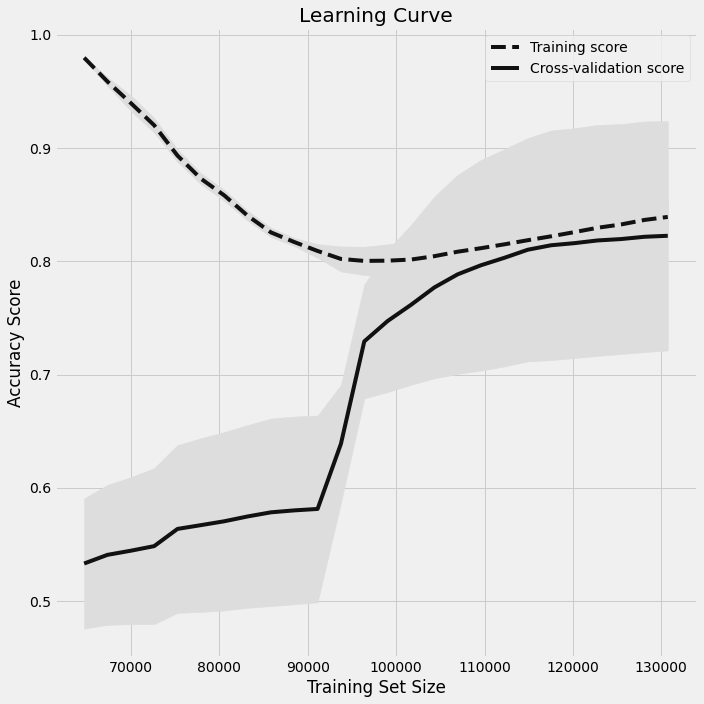

Wall time: 12min 23s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    26520
0    21416
Name: gender, dtype: int64


              counter
churn gender         
0     0         10027
      1         15295
1     0         11389
      1         11225
# # # # # # # # # # 
[[20251  2781]
 [ 5071 19833]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


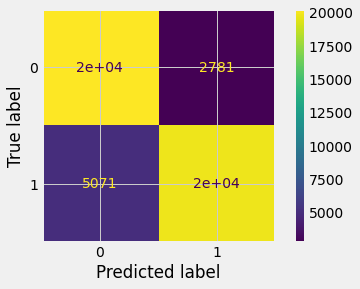




ROC AUC Score 0.9081817876372955
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.10853319518089127

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.2564187381912906

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 22614.0, 'FP': 0.0, 'TN': 25322.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.108533,22614.0,25322.0,[0.6926026368491052],1.256419,[0.6926026368491052],0.108533


Wall time: 17min 35s


In [18]:
%%time
runModels(3, 2)

Charn values Original
1    70000
0    70000
Name: churn, dtype: int64
Total data: 140000

Charn values Train
1    46923
0    46877
Name: churn, dtype: int64
Total data: 93800

Charn values Test
0    23123
1    23077
Name: churn, dtype: int64
Total data: 46200


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.8231642857142857
              precision    recall  f1-score   support

           0       0.91      0.78      0.84     26878
           1       0.75      0.89      0.82     19322

    accuracy                           0.83     46200
   macro avg       0.83      0.84      0.83     46200
weighted avg       0.84      0.83      0.83     46200

Creating Learning curve for Gradient Boosting - smote


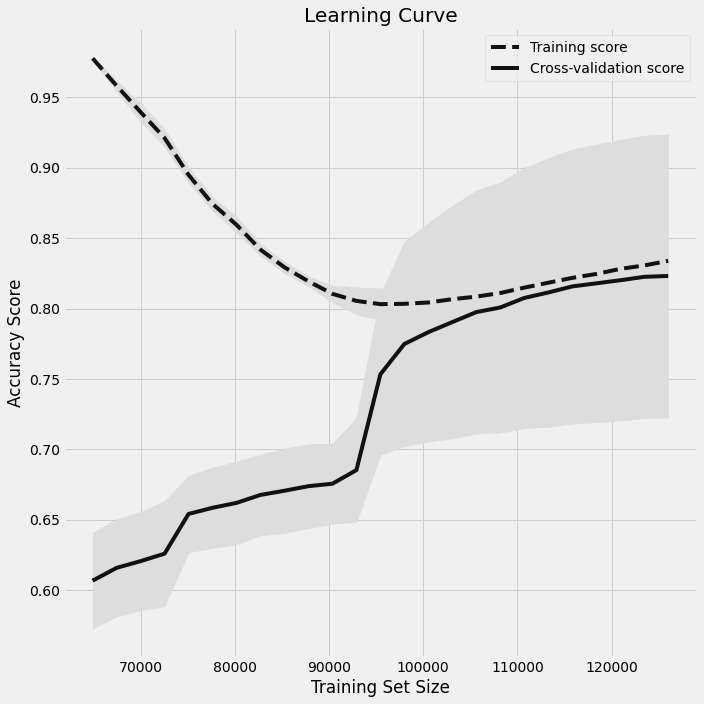

Wall time: 11min 25s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    25910
0    20290
Name: gender, dtype: int64


              counter
churn gender         
0     0         10599
      1         16279
1     0          9691
      1          9631
# # # # # # # # # # 
[[21082  2041]
 [ 5796 17281]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


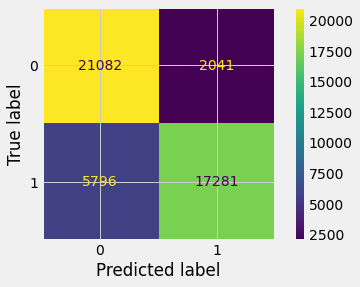




ROC AUC Score 0.9034959819894202
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.1059146809700105

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.2849391946768738

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 19322.0, 'FP': 0.0, 'TN': 26878.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.105915,19322.0,26878.0,[0.7801212121212175],1.284939,[0.7801212121212175],0.105915


Wall time: 15min 32s


In [19]:
%%time
runModels(3, 3)

Charn values Original
1    30000
0    30000
Name: churn, dtype: int64
Total data: 60000

Charn values Train
0    20167
1    20033
Name: churn, dtype: int64
Total data: 40200

Charn values Test
1    9967
0    9833
Name: churn, dtype: int64
Total data: 19800


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.7409166666666668
              precision    recall  f1-score   support

           0       0.81      0.72      0.76     11118
           1       0.69      0.79      0.73      8682

    accuracy                           0.75     19800
   macro avg       0.75      0.75      0.75     19800
weighted avg       0.76      0.75      0.75     19800

Creating Learning curve for Gradient Boosting - rus


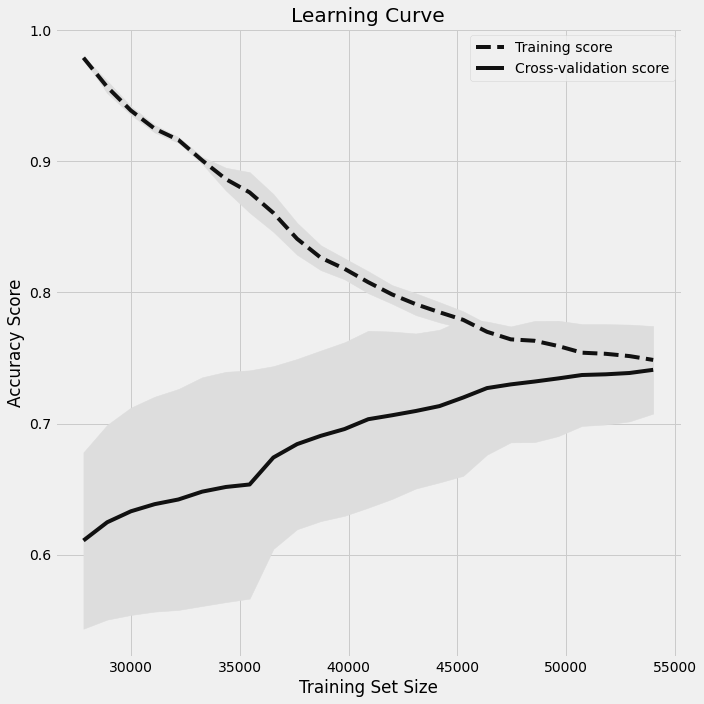

Wall time: 3min 4s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    12284
0     7516
Name: gender, dtype: int64


              counter
churn gender         
0     0          4429
      1          6689
1     0          3087
      1          5595
# # # # # # # # # # 
[[7985 1848]
 [3133 6834]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


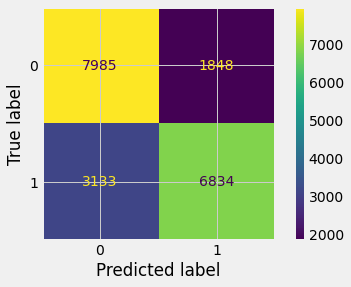




ROC AUC Score 0.8240414306905659
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.04474674152213476

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.9017571094087751

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 8682.0, 'FP': 0.0, 'TN': 11118.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.044747,8682.0,11118.0,[0.7678585858586011],0.901757,[0.7678585858586011],-0.044747


Wall time: 4min 29s


In [20]:
%%time
runModels(3, 4)

Charn values Original
1    70000
0    70000
Name: churn, dtype: int64
Total data: 140000

Charn values Train
1    46923
0    46877
Name: churn, dtype: int64
Total data: 93800

Charn values Test
0    23123
1    23077
Name: churn, dtype: int64
Total data: 46200


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.7396357142857143
              precision    recall  f1-score   support

           0       0.80      0.72      0.76     25648
           1       0.69      0.77      0.73     20552

    accuracy                           0.74     46200
   macro avg       0.74      0.75      0.74     46200
weighted avg       0.75      0.74      0.75     46200

Creating Learning curve for Gradient Boosting - ros


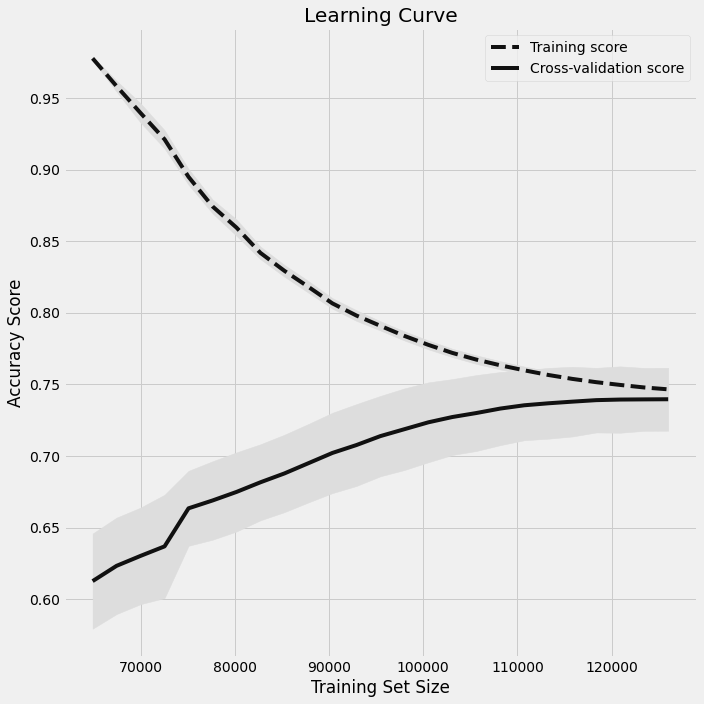

Wall time: 11min 41s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    28703
0    17497
Name: gender, dtype: int64


              counter
churn gender         
0     0         10162
      1         15486
1     0          7335
      1         13217
# # # # # # # # # # 
[[18493  4630]
 [ 7155 15922]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


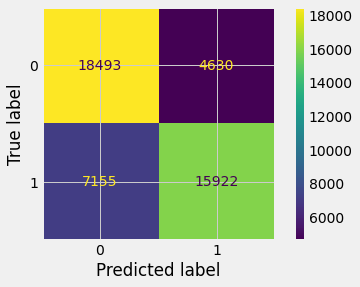




ROC AUC Score 0.8224656951413067
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.041259792335212764

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.910397229371445

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 20552.0, 'FP': 0.0, 'TN': 25648.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.04126,20552.0,25648.0,[0.7908961038961114],0.910397,[0.7908961038961114],-0.04126


Wall time: 15min 33s


In [21]:
%%time
runModels(3, 5)

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver optio

Charn values Original
0    70000
1    30000
Name: churn, dtype: int64
Total data: 100000

Charn values Train
0    46896
1    20104
Name: churn, dtype: int64
Total data: 67000

Charn values Test
0    23104
1     9896
Name: churn, dtype: int64
Total data: 33000


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.70238
              precision    recall  f1-score   support

           0       0.98      0.73      0.84     31106
           1       0.15      0.81      0.26      1894

    accuracy                           0.74     33000
   macro avg       0.57      0.77      0.55     33000
weighted avg       0.94      0.74      0.81     33000

Creating Learning curve for Logistic Reg. - original


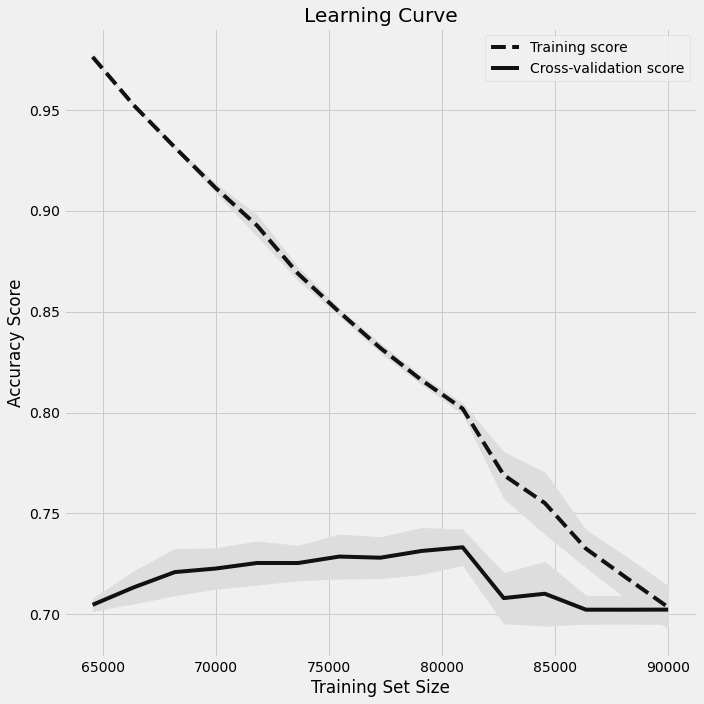

Wall time: 1min 15s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    20349
0    12651
Name: gender, dtype: int64


              counter
churn gender         
0     0         11906
      1         19200
1     0           745
      1          1149
# # # # # # # # # # 
[[22740   364]
 [ 8366  1530]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


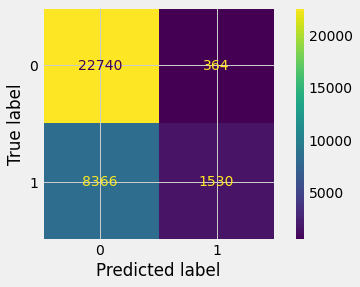




ROC AUC Score 0.6753710017702108
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.002423934265492575

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.04292831885858

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 1894.0, 'FP': 0.0, 'TN': 31106.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.002424,1894.0,31106.0,[0.9886363636363636],1.042928,[0.9886363636363636],0.002424


Wall time: 1min 22s


In [22]:
%%time
runModels(4, 1)

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver optio

Charn values Original
1    75259
0    70000
Name: churn, dtype: int64
Total data: 145259

Charn values Train
1    50355
0    46968
Name: churn, dtype: int64
Total data: 97323

Charn values Test
1    24904
0    23032
Name: churn, dtype: int64
Total data: 47936


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.5352987634730816


lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

           0       0.93      0.54      0.68     39212
           1       0.28      0.80      0.42      8724

    accuracy                           0.59     47936
   macro avg       0.60      0.67      0.55     47936
weighted avg       0.81      0.59      0.64     47936

Creating Learning curve for Logistic Reg. - adasyn


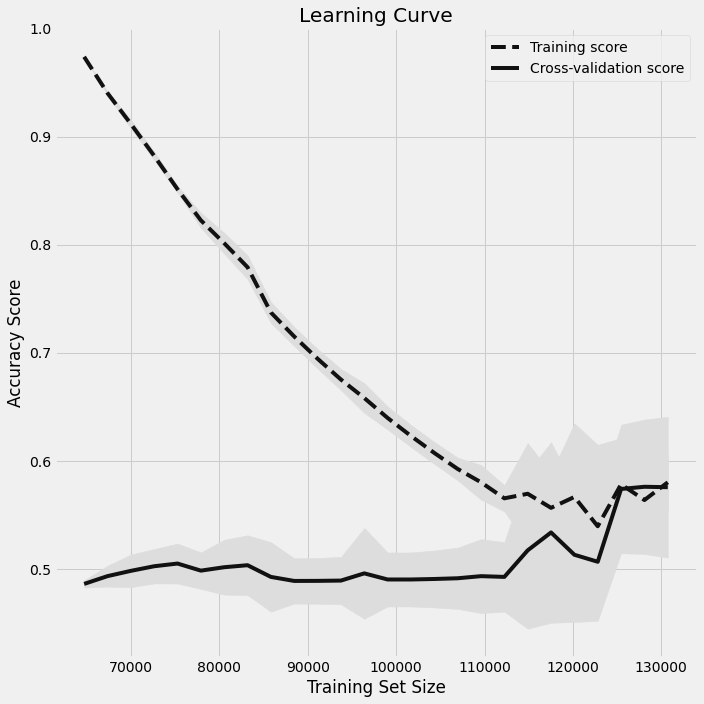

Wall time: 1min 42s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    26520
0    21416
Name: gender, dtype: int64


              counter
churn gender         
0     0         17352
      1         21860
1     0          4064
      1          4660
# # # # # # # # # # 
[[21307  1725]
 [17905  6999]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


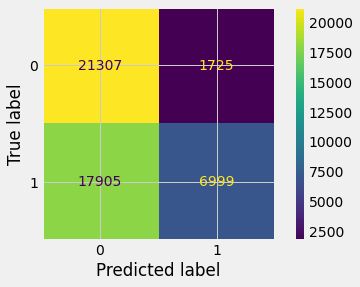




ROC AUC Score 0.6374357386480096
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.014048221512679093

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.0799482477502682

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 8724.0, 'FP': 0.0, 'TN': 39212.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.014048,8724.0,39212.0,[0.9867823765020026],1.079948,[0.9867823765020026],0.014048


Wall time: 3min 5s


In [23]:
%%time
runModels(4, 2)

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver optio

Charn values Original
1    70000
0    70000
Name: churn, dtype: int64
Total data: 140000

Charn values Train
1    46923
0    46877
Name: churn, dtype: int64
Total data: 93800

Charn values Test
0    23123
1    23077
Name: churn, dtype: int64
Total data: 46200


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.6405428571428572
              precision    recall  f1-score   support

           0       0.63      0.64      0.63     22597
           1       0.65      0.63      0.64     23603

    accuracy                           0.64     46200
   macro avg       0.64      0.64      0.64     46200
weighted avg       0.64      0.64      0.64     46200

Creating Learning curve for Logistic Reg. - smote


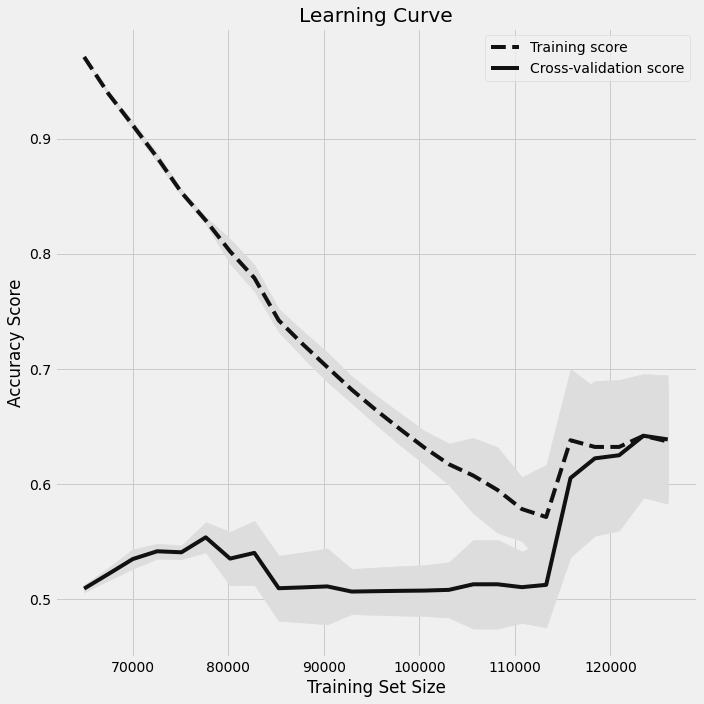

Wall time: 1min 46s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    25910
0    20290
Name: gender, dtype: int64


              counter
churn gender         
0     0          9231
      1         13366
1     0         11059
      1         12544
# # # # # # # # # # 
[[14503  8620]
 [ 8094 14983]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


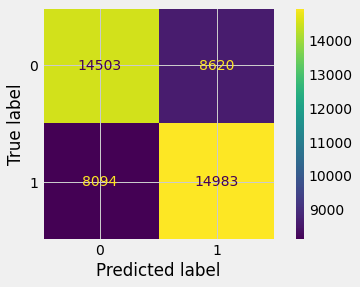




ROC AUC Score 0.6804699930073018
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.060909422406369707

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.1258101988639222

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 23603.0, 'FP': 0.0, 'TN': 22597.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.060909,23603.0,22597.0,[0.8570692640692823],1.12581,[0.8570692640692823],0.060909


Wall time: 2min 23s


In [24]:
%%time
runModels(4, 3)

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver optio

Charn values Original
1    30000
0    30000
Name: churn, dtype: int64
Total data: 60000

Charn values Train
0    20167
1    20033
Name: churn, dtype: int64
Total data: 40200

Charn values Test
1    9967
0    9833
Name: churn, dtype: int64
Total data: 19800


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.6646333333333333
              precision    recall  f1-score   support

           0       0.65      0.63      0.64     10258
           1       0.61      0.64      0.63      9542

    accuracy                           0.63     19800
   macro avg       0.63      0.63      0.63     19800
weighted avg       0.63      0.63      0.63     19800

Creating Learning curve for Logistic Reg. - rus


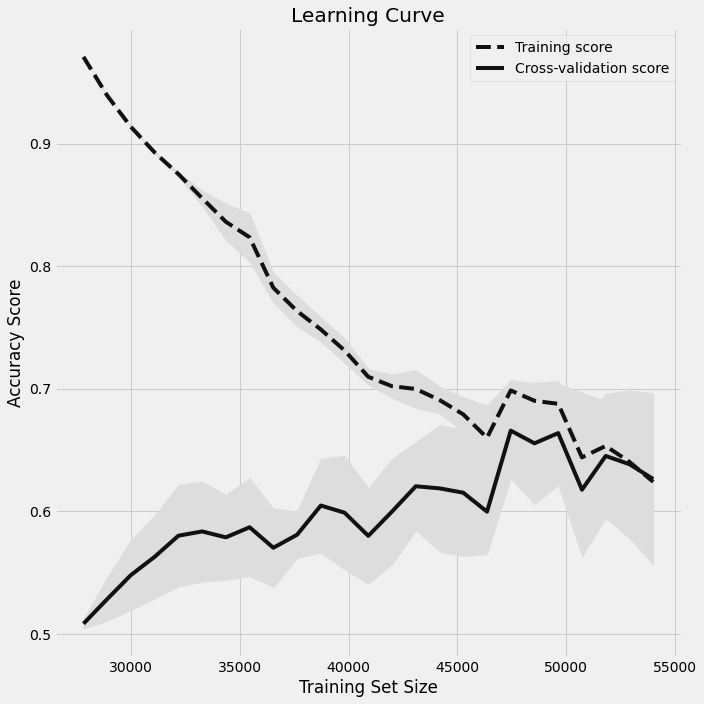

Wall time: 1min 7s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    12284
0     7516
Name: gender, dtype: int64


              counter
churn gender         
0     0          3755
      1          6503
1     0          3761
      1          5781
# # # # # # # # # # 
[[6414 3419]
 [3844 6123]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


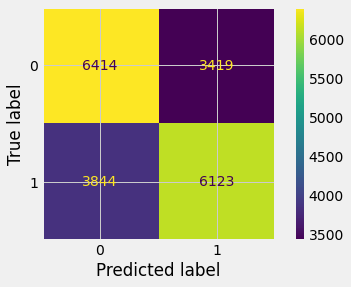




ROC AUC Score 0.6791666338028685
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.02978697003973202

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.0632940909821949

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 9542.0, 'FP': 0.0, 'TN': 10258.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.029787,9542.0,10258.0,[0.8268484848484902],1.063294,[0.8268484848484902],0.029787


Wall time: 1min 15s


In [25]:
%%time
runModels(4, 4)

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver optio

Charn values Original
1    70000
0    70000
Name: churn, dtype: int64
Total data: 140000

Charn values Train
1    46923
0    46877
Name: churn, dtype: int64
Total data: 93800

Charn values Test
0    23123
1    23077
Name: churn, dtype: int64
Total data: 46200


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.6469142857142858


lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

           0       0.82      0.63      0.71     29835
           1       0.53      0.74      0.61     16365

    accuracy                           0.67     46200
   macro avg       0.67      0.69      0.66     46200
weighted avg       0.71      0.67      0.68     46200

Creating Learning curve for Logistic Reg. - ros


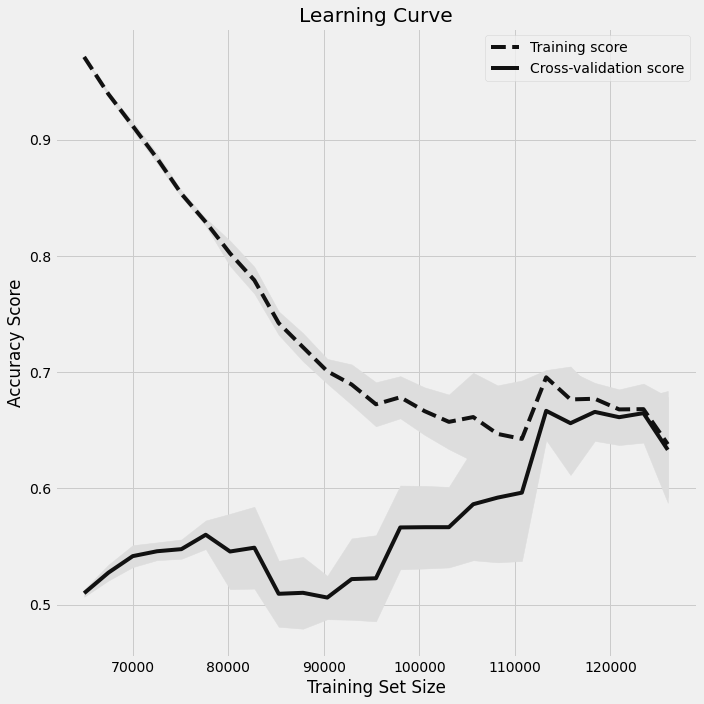

Wall time: 2min 19s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    28703
0    17497
Name: gender, dtype: int64


              counter
churn gender         
0     0         11170
      1         18665
1     0          6327
      1         10038
# # # # # # # # # # 
[[18882  4241]
 [10953 12124]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


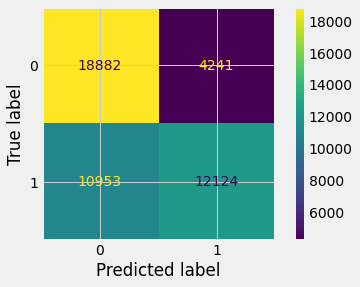




ROC AUC Score 0.6972822414540689
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.011885305033781768

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.0339852470994857

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 16365.0, 'FP': 0.0, 'TN': 29835.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.011885,16365.0,29835.0,[0.9590086580086568],1.033985,[0.9590086580086568],0.011885


Wall time: 2min 43s


In [26]:
%%time
runModels(4, 5)

In [27]:
import warnings
warnings.filterwarnings('ignore')

[19:03:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:03:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:04:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:04:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

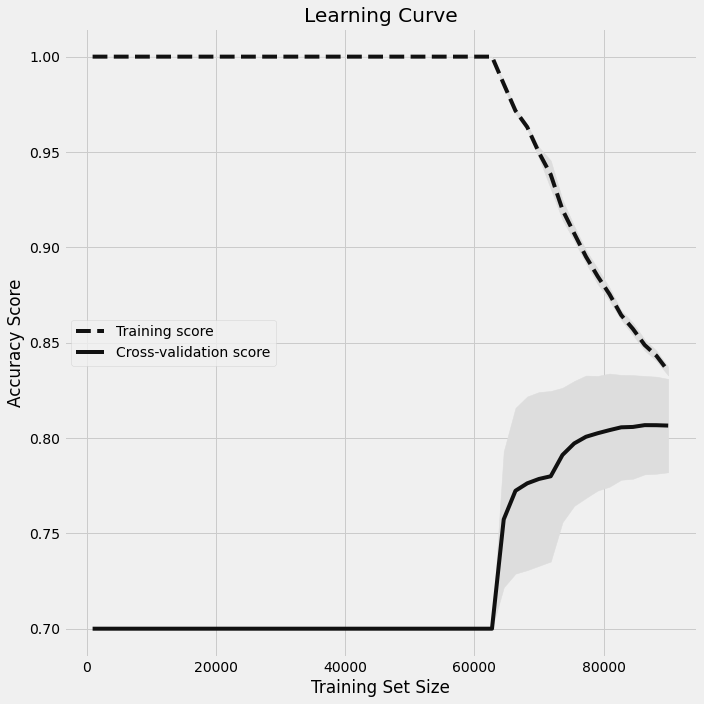

Wall time: 4min 25s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    20349
0    12651
Name: gender, dtype: int64


              counter
churn gender         
0     0         10449
      1         16061
1     0          2202
      1          4288
# # # # # # # # # # 
[[21595  1509]
 [ 4915  4981]]


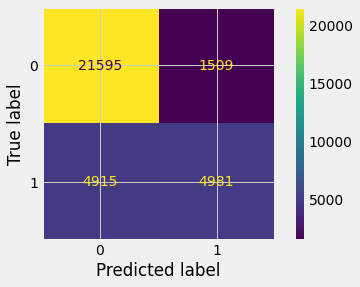




ROC AUC Score 0.8221319525173998
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.03666549887764184

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.8260013440622356

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 6490.0, 'FP': 0.0, 'TN': 26510.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.036665,6490.0,26510.0,[0.8945878787878847],0.826001,[0.8945878787878847],-0.036665


Wall time: 5min 1s


In [28]:
%%time
runModels(5, 1)

[19:09:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:10:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:10:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:10:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

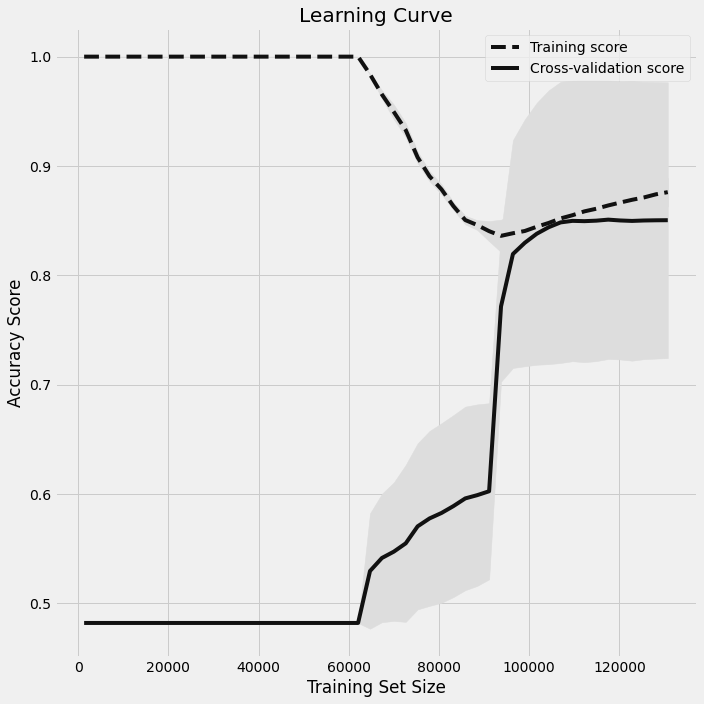

Wall time: 8min 29s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    26520
0    21416
Name: gender, dtype: int64


              counter
churn gender         
0     0         10428
      1         15727
1     0         10988
      1         10793
# # # # # # # # # # 
[[21245  1787]
 [ 4910 19994]]


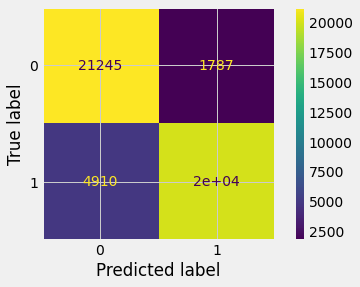




ROC AUC Score 0.9254832443348698
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.10609846967435577

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.260699658645781

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 21781.0, 'FP': 0.0, 'TN': 26155.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.106098,21781.0,26155.0,[0.6903454606141273],1.2607,[0.6903454606141273],0.106098


Wall time: 10min 25s


In [29]:
%%time
runModels(5, 2)

[19:19:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:19:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:19:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:19:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

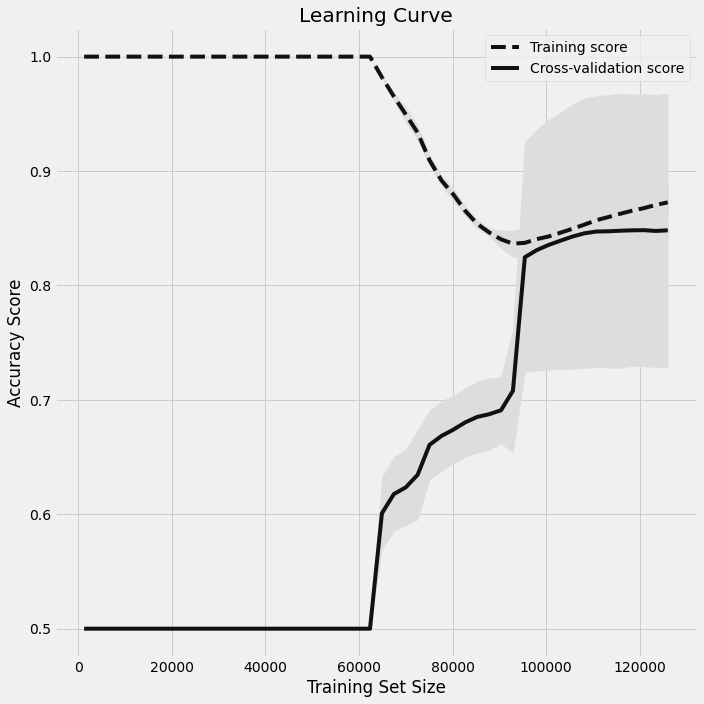

Wall time: 7min 58s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    25910
0    20290
Name: gender, dtype: int64


              counter
churn gender         
0     0         10331
      1         15899
1     0          9959
      1         10011
# # # # # # # # # # 
[[21359  1764]
 [ 4871 18206]]


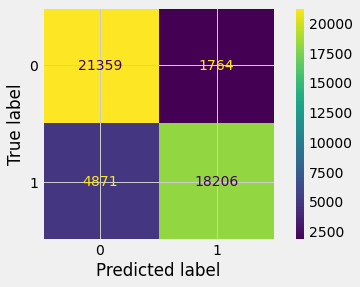




ROC AUC Score 0.9209851768166986
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.1044570059874772

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.2703507167251558

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 19970.0, 'FP': 0.0, 'TN': 26230.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.104457,19970.0,26230.0,[0.7548744588744549],1.270351,[0.7548744588744549],0.104457


Wall time: 9min 3s


In [30]:
%%time
runModels(5, 3)

[19:28:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:28:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:28:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:28:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

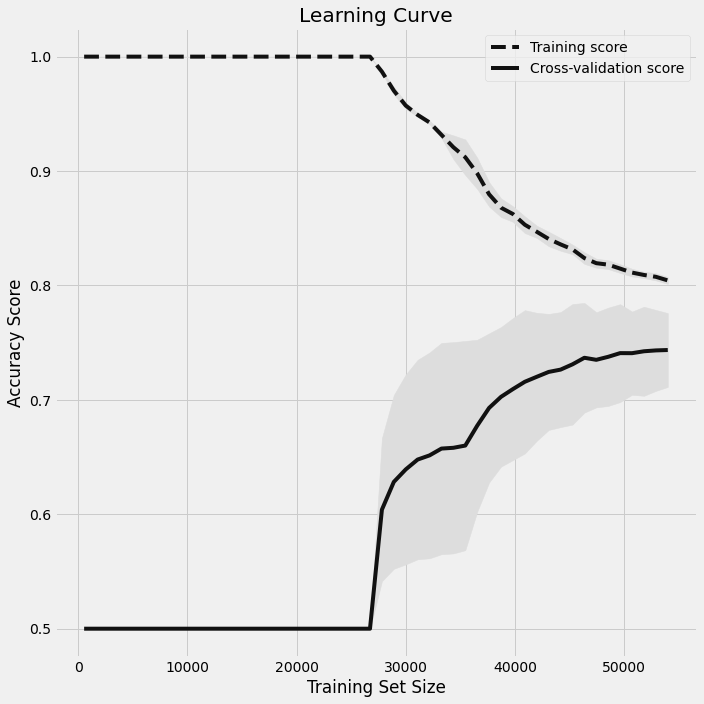

Wall time: 3min 22s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    12284
0     7516
Name: gender, dtype: int64


              counter
churn gender         
0     0          4391
      1          6463
1     0          3125
      1          5821
# # # # # # # # # # 
[[7838 1995]
 [3016 6951]]


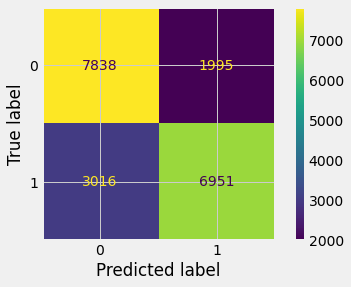




ROC AUC Score 0.8264394999175098
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.058088776722759194

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.8774158163095046

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 8946.0, 'FP': 0.0, 'TN': 10854.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.058089,8946.0,10854.0,[0.7527070707070876],0.877416,[0.7527070707070876],-0.058089


Wall time: 3min 45s


In [31]:
%%time
runModels(5, 4)

[19:32:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:32:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:32:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:32:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

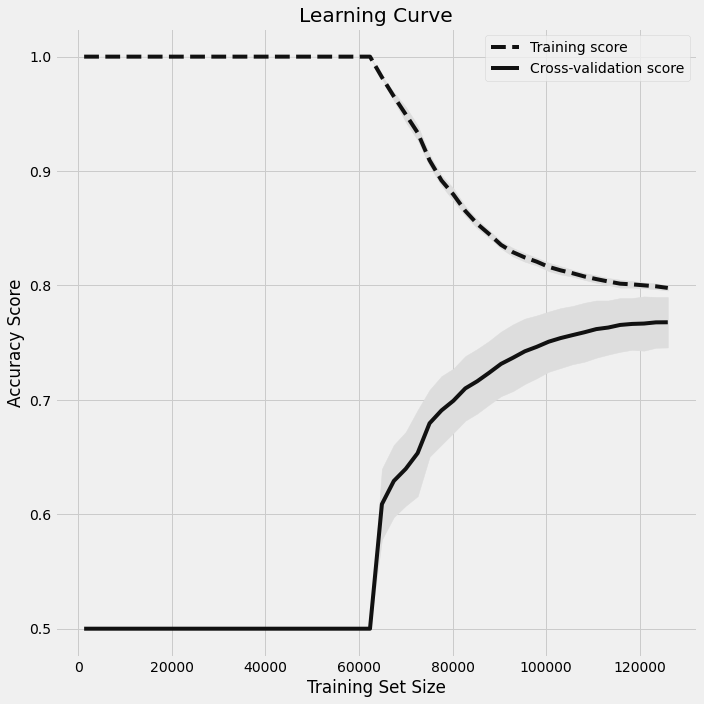

Wall time: 7min 45s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    28703
0    17497
Name: gender, dtype: int64


              counter
churn gender         
0     0         10073
      1         14889
1     0          7424
      1         13814
# # # # # # # # # # 
[[18719  4404]
 [ 6243 16834]]


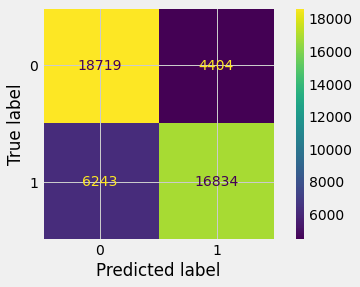




ROC AUC Score 0.8529815346924381
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.05697242565705107

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.8816215771221705

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 21238.0, 'FP': 0.0, 'TN': 24962.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.056972,21238.0,24962.0,[0.7727272727272732],0.881622,[0.7727272727272732],-0.056972


Wall time: 8min 33s


In [32]:
%%time
runModels(5, 5)

Charn values Original
0    70000
1    30000
Name: churn, dtype: int64
Total data: 100000

Charn values Train
0    46896
1    20104
Name: churn, dtype: int64
Total data: 67000

Charn values Test
0    23104
1     9896
Name: churn, dtype: int64
Total data: 33000


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.72018
              precision    recall  f1-score   support

           0       0.79      0.81      0.80     22645
           1       0.55      0.53      0.54     10355

    accuracy                           0.72     33000
   macro avg       0.67      0.67      0.67     33000
weighted avg       0.72      0.72      0.72     33000

Creating Learning curve for DecisionTreeClassifier - original


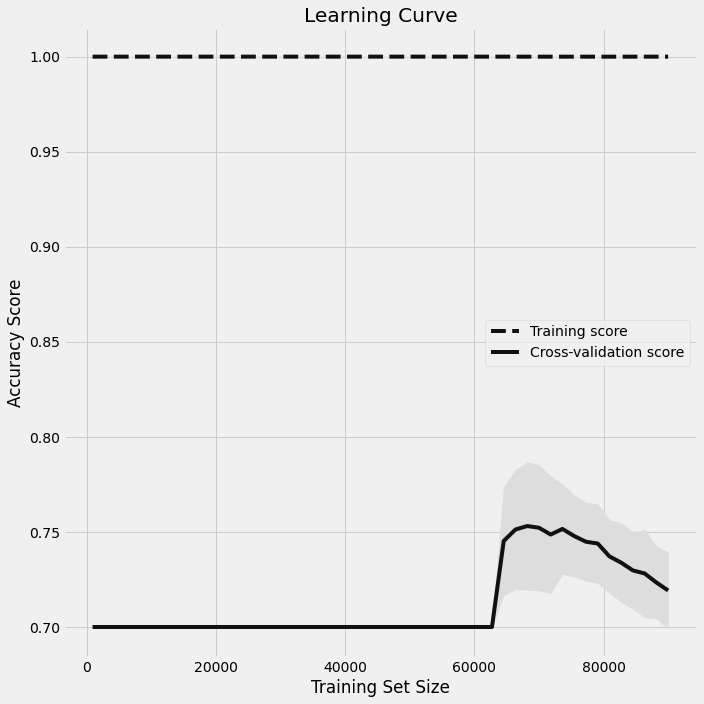

Wall time: 22.6 s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    20349
0    12651
Name: gender, dtype: int64


              counter
churn gender         
0     0          8885
      1         13760
1     0          3766
      1          6589
# # # # # # # # # # 
[[18236  4868]
 [ 4409  5487]]


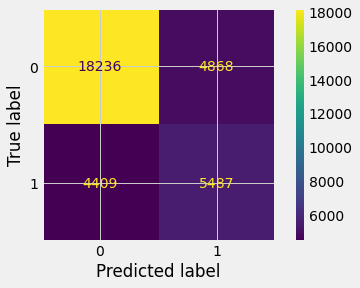




ROC AUC Score 0.6719233823313709
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.026115717765541502

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.9193460706008493

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 10355.0, 'FP': 0.0, 'TN': 22645.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.026116,10355.0,22645.0,[0.7424666666666946],0.919346,[0.7424666666666946],-0.026116


Wall time: 38.5 s


In [33]:
%%time
runModels(6, 1)

Charn values Original
1    75259
0    70000
Name: churn, dtype: int64
Total data: 145259

Charn values Train
1    50355
0    46968
Name: churn, dtype: int64
Total data: 97323

Charn values Test
1    24904
0    23032
Name: churn, dtype: int64
Total data: 47936


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.7870361820208196
              precision    recall  f1-score   support

           0       0.78      0.79      0.78     22658
           1       0.81      0.80      0.80     25278

    accuracy                           0.79     47936
   macro avg       0.79      0.79      0.79     47936
weighted avg       0.79      0.79      0.79     47936

Creating Learning curve for DecisionTreeClassifier - adasyn


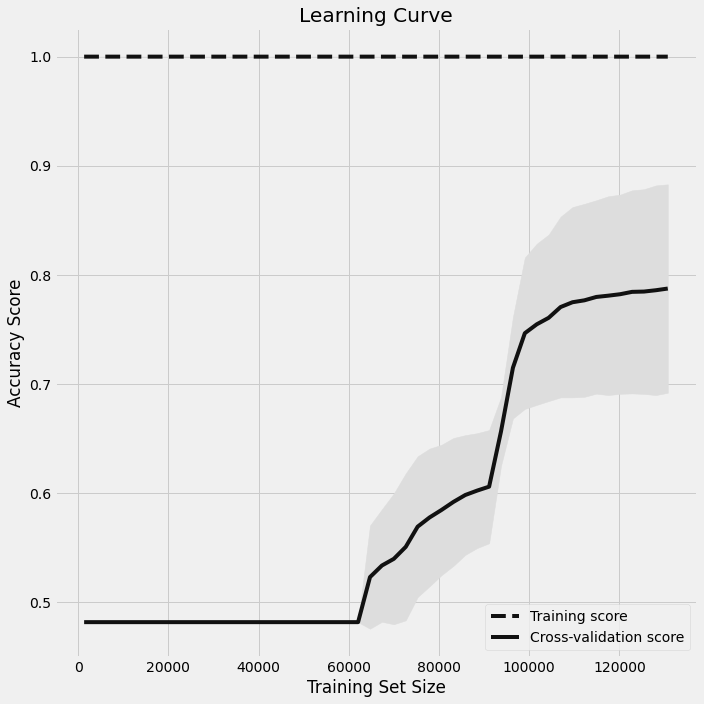

Wall time: 42.3 s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    26520
0    21416
Name: gender, dtype: int64


              counter
churn gender         
0     0          9006
      1         13652
1     0         12410
      1         12868
# # # # # # # # # # 
[[17917  5115]
 [ 4741 20163]]


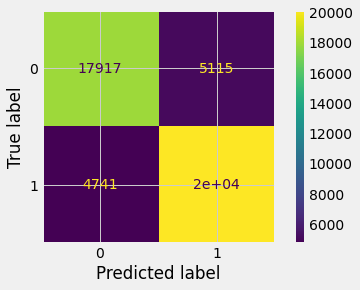




ROC AUC Score 0.7937733275074654
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.0942545881316234

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.1942517622979991

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 25278.0, 'FP': 0.0, 'TN': 22658.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.094255,25278.0,22658.0,[0.660530707610116],1.194252,[0.660530707610116],0.094255


Wall time: 2min 5s


In [34]:
%%time
runModels(6, 2)

Charn values Original
1    70000
0    70000
Name: churn, dtype: int64
Total data: 140000

Charn values Train
1    46923
0    46877
Name: churn, dtype: int64
Total data: 93800

Charn values Test
0    23123
1    23077
Name: churn, dtype: int64
Total data: 46200


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.7826642857142857
              precision    recall  f1-score   support

           0       0.78      0.79      0.78     22692
           1       0.80      0.78      0.79     23508

    accuracy                           0.79     46200
   macro avg       0.79      0.79      0.79     46200
weighted avg       0.79      0.79      0.79     46200

Creating Learning curve for DecisionTreeClassifier - smote


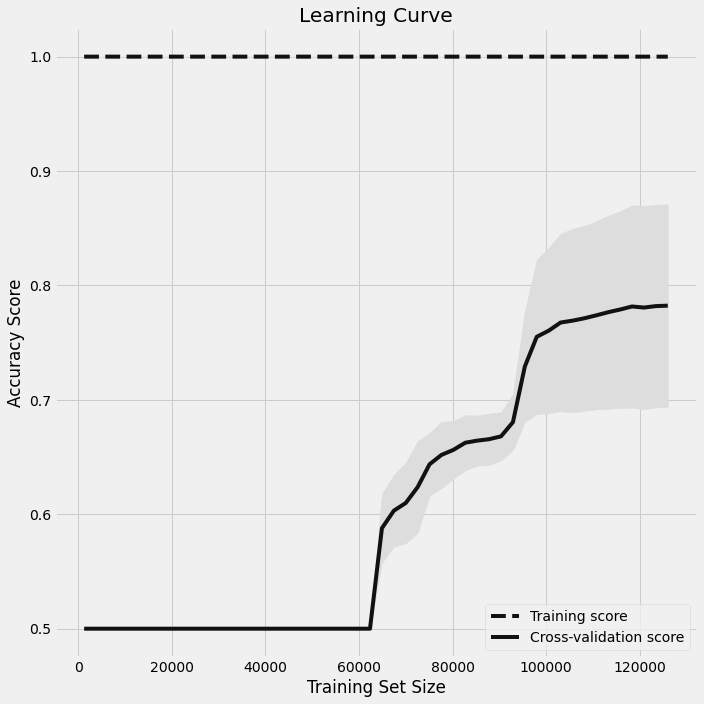

Wall time: 42.1 s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    25910
0    20290
Name: gender, dtype: int64


              counter
churn gender         
0     0          8916
      1         13776
1     0         11374
      1         12134
# # # # # # # # # # 
[[17978  5145]
 [ 4714 18363]]


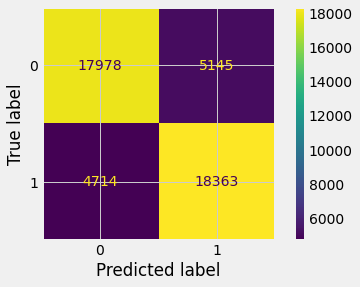




ROC AUC Score 0.7866613456341743
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.09225831768952653

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.1970012371300174

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 23508.0, 'FP': 0.0, 'TN': 22692.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.092258,23508.0,22692.0,[0.7001904761904539],1.197001,[0.7001904761904539],0.092258


Wall time: 1min 17s


In [35]:
%%time
runModels(6, 3)

Charn values Original
1    30000
0    30000
Name: churn, dtype: int64
Total data: 60000

Charn values Train
0    20167
1    20033
Name: churn, dtype: int64
Total data: 40200

Charn values Test
1    9967
0    9833
Name: churn, dtype: int64
Total data: 19800


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.6609499999999999
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      9897
           1       0.66      0.66      0.66      9903

    accuracy                           0.66     19800
   macro avg       0.66      0.66      0.66     19800
weighted avg       0.66      0.66      0.66     19800

Creating Learning curve for DecisionTreeClassifier - rus


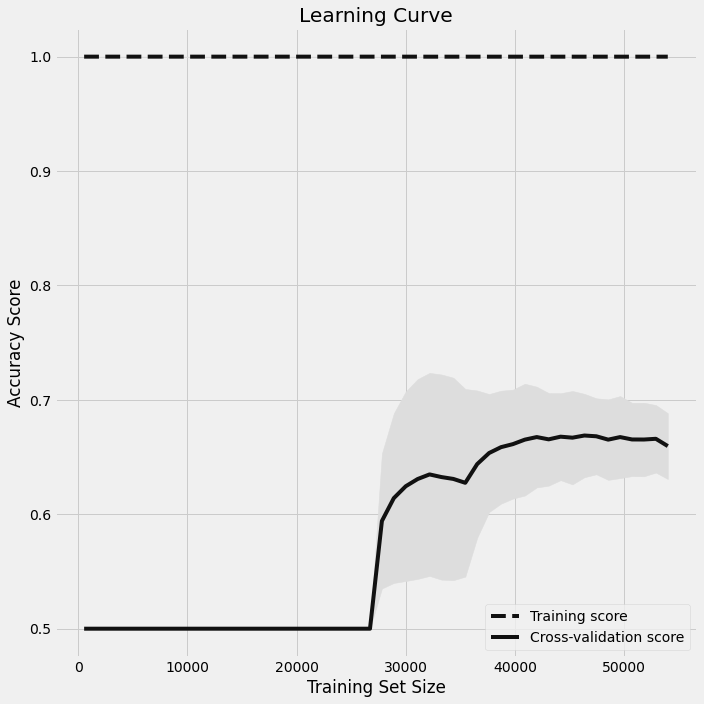

Wall time: 15.2 s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    12284
0     7516
Name: gender, dtype: int64


              counter
churn gender         
0     0          3881
      1          6016
1     0          3635
      1          6268
# # # # # # # # # # 
[[6489 3344]
 [3408 6559]]


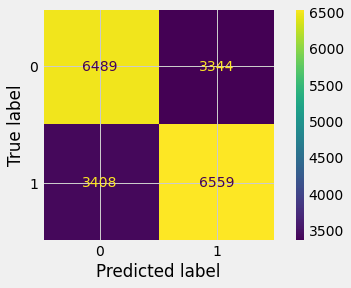




ROC AUC Score 0.6589961558386243
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.02662233300967054

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.9478256638974485

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 9903.0, 'FP': 0.0, 'TN': 9897.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.026622,9903.0,9897.0,[0.6896161616161898],0.947826,[0.6896161616161898],-0.026622


Wall time: 24.3 s


In [36]:
%%time
runModels(6, 4)

Charn values Original
1    70000
0    70000
Name: churn, dtype: int64
Total data: 140000

Charn values Train
1    46923
0    46877
Name: churn, dtype: int64
Total data: 93800

Charn values Test
0    23123
1    23077
Name: churn, dtype: int64
Total data: 46200


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.8652785714285715
              precision    recall  f1-score   support

           0       0.76      0.88      0.82     19861
           1       0.90      0.79      0.84     26339

    accuracy                           0.83     46200
   macro avg       0.83      0.84      0.83     46200
weighted avg       0.84      0.83      0.83     46200

Creating Learning curve for DecisionTreeClassifier - ros


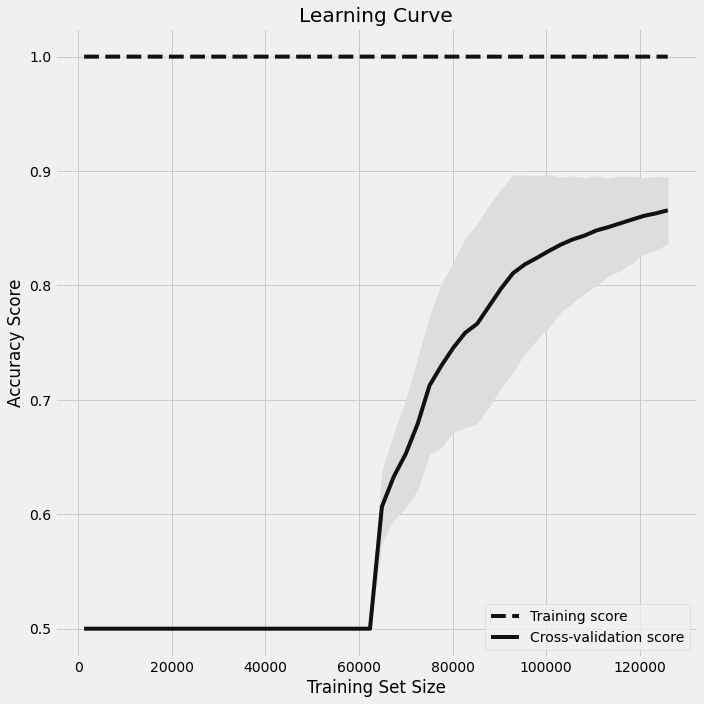

Wall time: 43.9 s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    28703
0    17497
Name: gender, dtype: int64


              counter
churn gender         
0     0          7910
      1         11951
1     0          9587
      1         16752
# # # # # # # # # # 
[[17530  5593]
 [ 2331 20746]]


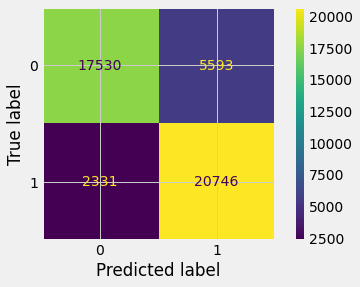




ROC AUC Score 0.828544497479506
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.03570987192251951

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.9388144428252103

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 26339.0, 'FP': 0.0, 'TN': 19861.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.03571,26339.0,19861.0,[0.7052683982683806],0.938814,[0.7052683982683806],-0.03571


Wall time: 1min 6s


In [37]:
%%time
runModels(6, 5)